In [1]:
import numpy as np
from scipy.optimize import root

import sys
sys.path.append("..") 

from SciComp.bvp import BVP

def euler_step(fun, t, y, h):
    """Perform one step of the Euler method.
    
    parameters
    ----------
    fun : function
        Function f(t, y) to integrate.
    t : float
        Current value of t.
    y : float
        Current value of y.
    h : float
        Step size.
        
    returns
    -------
    t : float
        New value of t.
    y : float
        New value of y.
    """
    m = fun(t, y)
    t = t + h
    y = y + h*m

    return t, y   


In [2]:
from SciComp.ivp import solve_ode
from SciComp._ode_solvers import rk4_step, euler_step, heun_step

def solve_ode(fun, t0, y0, tf=None, n_max=None, method='RK4', deltat_max=0.01, args=None, t_array=None):
    t = t0
    y = y0
    t_array = [t]
    y_array = [y]
    step = 0

    while (tf is None or t < tf) and (n_max is None or step < n_max):
        t, y = euler_step(fun, t, y, deltat_max)
        t_array.append(t)
        y_array.append(y)
        step += 1

        # Prevent overshooting tf
        if tf is not None and t + deltat_max > tf:
            deltat_max = tf - t

    return np.array(t_array), np.array(y_array)


def explicit_method(bvp, t, method='Euler'):
    """
    Function to solve the PDE using the explicit methods. It uses centered finite differences to
    convert the PDE into an ODE. Using the method of lines, the ODE is solved using a step function
    from _ode_solvers.py

    Parameters
    ----------
    bvp : BVP object
        Boundary value problem to solve. Object instantiated in SciComp/bvp.py.
    t : numpy.ndarray
        Array of time values.

    Returns
    -------
    solution : numpy.ndarray
        Solution to the PDE.
    """
    METHODS = {
        'Euler': euler_step,
        'RK4': rk4_step,
        'Heun': heun_step
    }
    if method not in METHODS:
        raise ValueError('Invalid method: {}. Method must be one of {}.'.format(method, METHODS.keys()))
    else:
        method = METHODS[method]

    A, b, x_array = bvp.construct_matrix()

    u = np.zeros((len(x_array.T), len(t)))

    u[:, 0] = bvp.f_fun(x_array, t[0])
    u[0, :] = bvp.alpha
    u[-1, :] = bvp.beta

    # Loop over starting points and solve using solve_ode(fun, t0, y0, tf=None, n_max=None, method='RK4', deltat_max=0.01, args=None):
    # fun must return a numpy array. y0 must be a numpy array.
    def PDE(t, u):
        return bvp.C * (A @ u + b)

    nT = len(t)
    t_ = t[0]

    for n in range(0, nT-1):
        t_, u[:, n+1] = euler_step(PDE, t_, u[:, n], 1)
    
    u = bvp.concatanate(u, type='PDE', t=t)
    return u

# u = explicit_method(bvp, t, method='Euler')

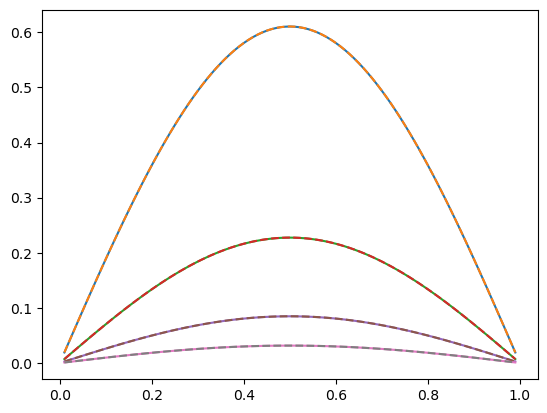

In [5]:
from SciComp.plotting import plot_PDE_fixed_time

# Define PDE 
a = 0
b = 1
alpha = 0
beta = 0
def f_fun(X, T): 
    return np.sin(np.pi * (X - a) / (b - a))
D = 1
N = 100

bvp = BVP(a, b, N, alpha, beta, D=D, condition_type='Dirichlet', f_fun=f_fun)

t_boundary = 0
C = 0.5
t_final = 2

t, dt, C = bvp.time_discretization(t_boundary, t_final, C=C, method='Explicit Euler')
A_, b_, x_array = bvp.construct_matrix()


u = explicit_method(bvp, t, method='Euler')    

# Get analytical solution
analytic_sol = lambda x, t: np.exp(-D * np.pi**2 * t / (b-a)**2) * np.sin(np.pi * (x - a) / (b - a))

for index in [1000, 3000, 5000, 7000]:
    numerical_sol = u[:, index]
    analytical_sol = analytic_sol(x_array, t[index])

    import matplotlib.pyplot as plt
    plt.plot(x_array, numerical_sol, label='Numerical')
    plt.plot(x_array, analytical_sol, '--', label='Analytic')

plt.show()

In [66]:
u[:, 100]

array([0.00000000e+00, 2.49922750e-04, 6.26656192e-02, 9.41076950e-02,
       1.25332738e-01, 1.56433848e-01, 1.87380575e-01, 2.18142380e-01,
       2.48688905e-01, 2.78990005e-01, 3.09015775e-01, 3.38736583e-01,
       3.68123100e-01, 3.97146323e-01, 4.25777611e-01, 4.53988708e-01,
       4.81751772e-01, 5.09039406e-01, 5.35824680e-01, 5.62081159e-01,
       5.87782932e-01, 6.12904634e-01, 6.37421474e-01, 6.61309255e-01,
       6.84544404e-01, 7.07103990e-01, 7.28965750e-01, 7.50108109e-01,
       7.70510201e-01, 7.90151893e-01, 8.09013801e-01, 8.27077309e-01,
       8.44324593e-01, 8.60738629e-01, 8.76303221e-01, 8.91003007e-01,
       9.04823481e-01, 9.17751003e-01, 9.29772816e-01, 9.40877055e-01,
       9.51052762e-01, 9.60289895e-01, 9.68579338e-01, 9.75912909e-01,
       9.82283373e-01, 9.87684442e-01, 9.92110785e-01, 9.95558035e-01,
       9.98022789e-01, 9.99502615e-01, 9.99996052e-01, 9.99502615e-01,
       9.98022789e-01, 9.95558035e-01, 9.92110785e-01, 9.87684442e-01,
      

In [42]:
A, b, x_array = bvp.construct_matrix()

u = np.zeros((len(x_array), len(t)))
u[:, 0] = bvp.f_fun(x_array, t[0])
u[0, :] = bvp.alpha
u[-1, :] = bvp.beta

def PDE(t, u):
   return bvp.C * (A @ u + b)

C:\Users\duppu\AppData\Local\Temp\ipykernel_18072\2717889184.py:8: RuntimeWarning:

divide by zero encountered in divide

C:\Users\duppu\AppData\Local\Temp\ipykernel_18072\2717889184.py:8: RuntimeWarning:

invalid value encountered in sin



In [48]:
]

0.0

In [158]:
print(u.shape)